# Exercise 5: Sinusoidal model

In this exercise you will experiment with the sinusoidal model, measuring and tracking sinusoids in different kinds of audio signals. You will use the sinusoidal model to analyze short synthetic sounds with the goal to better understand various aspects of sinusoid estimation and tracking. You will experiment with different parameters and enhancements of the sinusoidal modeling approach. 

There are four parts in this exercise: 1) Minimizing the frequency estimation error of a sinusoid, 2) Tracking a two component chirp, 3) Tracking sinusoids of different amplitudes, and 4) Sinusoidal modeling of a multicomponent signal.

### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp. 

__Sinusoidal modeling and sine tracking:__ 
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking. 

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time. 
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies. 

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid. 

## Part 1 - Minimizing the frequency estimation error of a sinusoid

The function `min_freq_est_err()` should estimate the frequency of a sinusoidal signal at a given time instant. The function should return the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file should be a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size should be chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size should be the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`. 

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [1]:
import numpy as np
from scipy.signal import get_window
import math
import sys, os
sys.path.append('../software/models/')
import dftModel as DFT
import utilFunctions as UF
import stft
import sineModel as SM
import IPython.display as ipd

from dftModel import dftAnal, dftSynth

In [2]:
# E5 - 1.1: Complete the function min_freq_est_err()

def min_freq_est_err(input_file, f):
    """Best estimate the frequency of a sinusoid by iterating over different sizes of analysis window.
    
    Args:
            input_file (str): wav file
            f (float): frequency of the sinusoid present in the input audio signal (Hz)
            
    Result:
            f_est (float): estimated frequency of the sinusoid (Hz)
            M (int): Window size
            N (int): FFT size
            
    """
    # analysis parameters:
    window = 'blackman'
    t = -40 # to be used in UF.peakDetection()
        
    ### Your code here
    k = 1
    iterator_counter = 0
    while 1:
        M = 100*k + 1
        
        # calculate smallest power of 2 > M
        N = 0
        incrementer = 1
        while N < M:
            N = np.power(2,incrementer)
            incrementer += 1
            
        w = get_window(window, M)

        fs, x = UF.wavread(input_file)

        # Extract a sound frame from the input signal, of size M, centered at 0.5 s.
        # Compute input sound's sample index at time 0.5 s
        centr_samp_ind = math.floor((int(fs)-1) / 2)

        # Extract central frame of length M from input signal
        framed_x = x[centr_samp_ind - math.floor(M/2) -1 : centr_samp_ind + math.floor(M/2)]
        """
        # Apply 0 padding
        # framed_x = np.pad(framed_x, int((N-M)/2))
        """

        """
        print("sampling frequency ;")
        print(fs)
        print("time sample index at time 0.5 s ;")
        print(centr_samp_ind)
        print("M ;")
        print(M)
        print("length of framed_x ;")
        print(len(framed_x))
        """

        # Compute DFT of the single frame
        m_framedX, p_framedX = dftAnal(framed_x, w, N)
        # Extract peak locations with provided magnitude dB threshold
        peak_locs = UF.peakDetection(m_framedX, t) 
        # Compute parabolic interpolation of the peaks
        int_peak_locs, int_m_framedX, int_p_framedX = UF.peakInterp(m_framedX, p_framedX, peak_locs)
        # Calculate actual frequency value in hZ at the bin correspondent to the magnitude peak 
        peak_loc_hZ = (fs / N) * int_peak_locs

        """
        print("Loop iteration n.;")
        print(k)
        """

        # Calculate error between estimated frequency peak and actual frequency
        # if it's lower than threshold, validate the frequency estimation and end the while loop,
        # otherwise continue while loop
        if (peak_loc_hZ[0] > (f - 0.05)) and (peak_loc_hZ[0] < (f + 0.05)):
            f_est = peak_loc_hZ
            iterator_counter = k
            break
            
        k += 1
        # end of while loop
    
    print("Number of iterations needed;")
    print(iterator_counter)
    print("Target frequency;")
    print(f)
    print("M;")
    print(M)
    print("N;")
    print(N)
    print("Interpolated peak location in hZ;")
    print(peak_loc_hZ)
    print("Frequency estimation error;")
    print(abs(f-f_est))
    
    return f_est, M, N


Test cases for `min_freq_est_err()`:

__Test case 1:__ If you run your code with `input_file = '../sounds/sine-490.wav'`, `f = 490.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 489.963` and the frequency estimation error is 0.037.

__Test case 2:__ If you run your code with `input_file = '../sounds/sine-1000.wav'`, `f = 1000.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 1000.02` and the frequency estimation error is 0.02.

__Test case 3:__ If you run your code with `input_file = '../sounds/sine-200.wav'`, `f = 200.0 Hz`, the optimal
values are `M = 1201`, `N = 2048`, `f_est = 200.038` and the frequency estimation error is 0.038.

Interesting validation is to check if these frequency estimation errors are perceptually relevant. To do that you can generate and listen the estimated frequencies, by generating a sinusoid with that frequency, and check if you perceive a difference with the original sinusoid.

In [3]:
# E5 - 1.2: For each of the 3 test cases, play the input sinusoid, call the function min_freq_est_err(),  
# generate sinusoid with estimated frequency value, and play it. Explain the result.

### Your code here

print("\n")
input_file = '../sounds/sine-490.wav'
fs, x = UF.wavread(input_file)
ipd.display(ipd.Audio(rate=fs, data=x))
f = 490.0
min_freq_est_err(input_file, f)
T = 1/fs
time_values = np.arange(len(x))
y = np.cos(2 * np.pi * f * (time_values * T))
ipd.display(ipd.Audio(rate=fs, data=y))

print("\n")
input_file = '../sounds/sine-1000.wav'
fs, x = UF.wavread(input_file)
ipd.display(ipd.Audio(rate=fs, data=x))
f = 1000.0
min_freq_est_err(input_file, f)
T = 1/fs
time_values = np.arange(len(x))
y = np.cos(2 * np.pi * f * (time_values * T))
ipd.display(ipd.Audio(rate=fs, data=y))

print("\n")
input_file = '../sounds/sine-200.wav'
fs, x = UF.wavread(input_file)
ipd.display(ipd.Audio(rate=fs, data=x))
f = 200.0
min_freq_est_err(input_file, f)
T = 1/fs
time_values = np.arange(len(x))
y = np.cos(2 * np.pi * f * (time_values * T))
ipd.display(ipd.Audio(rate=fs, data=y))

# OPTIONAL test other sinewave input signals
print("\n")
input_file = '../sounds/sine-101.wav'
fs, x = UF.wavread(input_file)
ipd.display(ipd.Audio(rate=fs, data=x))
f = 101.0
min_freq_est_err(input_file, f)
T = 1/fs
time_values = np.arange(len(x))
y = np.cos(2 * np.pi * f * (time_values * T))
ipd.display(ipd.Audio(rate=fs, data=y))

print("\n")
input_file = '../sounds/sine-440.wav'
fs, x = UF.wavread(input_file)
ipd.display(ipd.Audio(rate=fs, data=x))
f = 440.0
min_freq_est_err(input_file, f)
T = 1/fs
time_values = np.arange(len(x))
y = np.cos(2 * np.pi * f * (time_values * T))
ipd.display(ipd.Audio(rate=fs, data=y))

""" Explanation
The parabolic interpolation function gives us an interpolated ("fictitious") frequency bin index.
To obtain the actual estimated frequency in hZ we have thus to multiply it by the distance between
each frequency bin, in hZ.

Since lower frequencies occur fewer times in the same time period, they need more samples to be properly described in the frequency domain.
This trend is confirmed by other 2 optional test cases I performed (101 hZ and 440 hZ).

In fact, in the formulas given in the lecture slides;

- M >= Bs * (fs / delta)
- M >= Bs * P (P = period in number of samples)

given that the signal is periodic (delta = fundamental frequency), which is our case,
the second formula is a semplificaiton of the first one, since fs / delta = P.
From these formulas (the second is more explicative; M >= Bs * P), we can see that, with the same main lobe width
(same window type), M increases as P increases, thus

M INCREASES AS THE FUNDAMENTAL FREQUENCY GETS LOWER.

In any test case the frequency estimation error is (to me) perceptually not relevant.
I can not perceive any difference in frequency.
"""


Number of iterations needed;
11
Target frequency;
490.0
M;
1101
N;
2048
Interpolated peak location in hZ;
[489.96301594]
Frequency estimation error;
[0.03698406]


Number of iterations needed;
11
Target frequency;
1000.0
M;
1101
N;
2048
Interpolated peak location in hZ;
[1000.01993337]
Frequency estimation error;
[0.01993337]


Number of iterations needed;
12
Target frequency;
200.0
M;
1201
N;
2048
Interpolated peak location in hZ;
[200.03814501]
Frequency estimation error;
[0.03814501]


Number of iterations needed;
12
Target frequency;
101.0
M;
1201
N;
2048
Interpolated peak location in hZ;
[100.95280702]
Frequency estimation error;
[0.04719298]


Number of iterations needed;
11
Target frequency;
440.0
M;
1101
N;
2048
Interpolated peak location in hZ;
[440.02278306]
Frequency estimation error;
[0.02278306]


' Explanation\nThe parabolic interpolation function gives us an interpolated ("fictitious") frequency bin index.\nTo obtain the actual estimated frequency in hZ we have thus to multiply it by the distance between\neach frequency bin, in hZ.\n\nSince lower frequencies occur fewer times in the same time period, they need more samples to be properly described in the frequency domain.\nThis trend is confirmed by other 2 optional test cases I performed (101 hZ and 440 hZ).\n\nIn fact, in the formulas given in the lecture slides;\n\n- M >= Bs * (fs / delta)\n- M >= Bs * P (P = period in number of samples)\n\ngiven that the signal is periodic (delta = fundamental frequency), which is our case,\nthe second formula is a semplificaiton of the first one, since fs / delta = P.\nFrom these formulas (the second is more explicative; M >= Bs * P), we can see that, with the same main lobe width\n(same window type), M increases as P increases, thus\n\nM INCREASES AS THE FUNDAMENTAL FREQUENCY GETS LOWER.

## Part 2 - Tracking a two component chirp 

In this part you should perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M`, of the function `sineModelAnal()`. 

You should use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies should result in a mean error smaller than 2Hz. 

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`. 

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. 

In [4]:
# functions used in exercises of Part 2 and 3

def gen_time_stamps(xlen, M, fs, H):
    """Generate frame time stamps for a given sound duration.
    
    Args:
        xlen (float): duration of sound in seconds
        M (int): window size
        fs (int): sampling rate 
        H (int): hop size
        
    Result:
        np.array: time stamps
        
    """
    hM1 = int(np.floor((M+1)/2))                     
    hM2 = int(np.floor(M/2))                         
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1                                     
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    """Generate the frequency values present in file "../sounds/chirp-150-190-linear.wav"
    
    Args: 
        tStamps (np.array): time stamps
        
    Result:
        np.array: time stamps and frequency values of predefined chirp
        
    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    """Generate the frequency values present in file "../sounds/sines-440-602-hRange.wav"
    
    Args: 
        tStamps (np.array): time stamps
        
    Result:
        np.array: time stamps and frequency values of predefined chirp
        
    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """Estimate sinusoidal values of a sound
    
    Args:
        input_file (str): wav file including the path
        fTrackTrue (np.array): array of true frequency values, one row per time frame, one column per component
        window (str): window type used for analysis
        t (float): peak picking threshold (negative dB)
        H (int): hop size in samples
        M (int): window size in samples
           
   Result:
           float: mean estimation error
           np.array: estimated frequency values, one row per time frame, one column per component
           
    """
  
    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation
    
    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20                                 
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)        
    
    return (meanErr, fTrackEst)

The most important input parameter of the function `freq_tracker_error()` in order to obtain the best possible results, that is, minimum error, is the window-size, `M`.

Ideally `M` should be chosen to obtain a mean estimation error (`meanErr`) of each frequency component less than 2Hz. There is a range of values of `M` for which this is true and all of those values would be good. Plotting the estimated and true frequency tracks shouldd be done to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks_150_190()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values. 

NOTE: Do not do just trial and error. Understand the problem and calculate the `M` that should work best. Then test it and refine the answer using the code.

__Test case:__ Choosing `M = 1023`, the mean estimation error should be `[13.669, 528.533]` Hz, which as you can see do not give us the desired estimation errors.

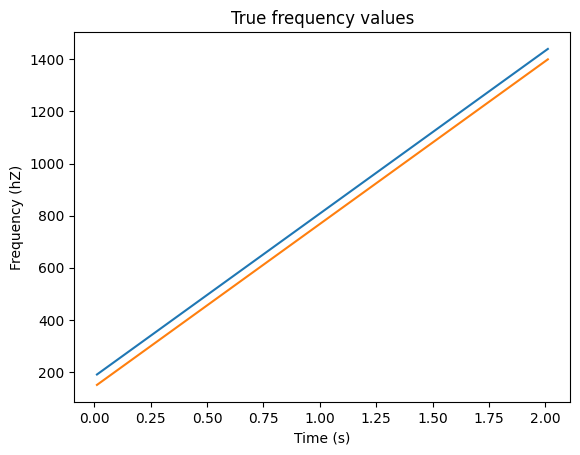

Test case Mean error;
[ 13.66932655 528.53338713]


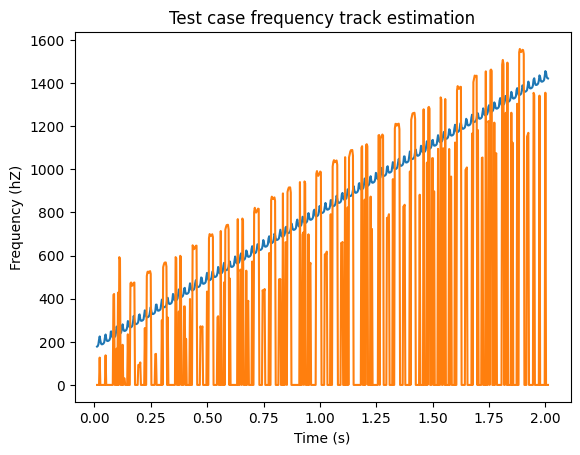

Computed M;
4410
Exercise Mean error;
[0.71733092 1.28664587]


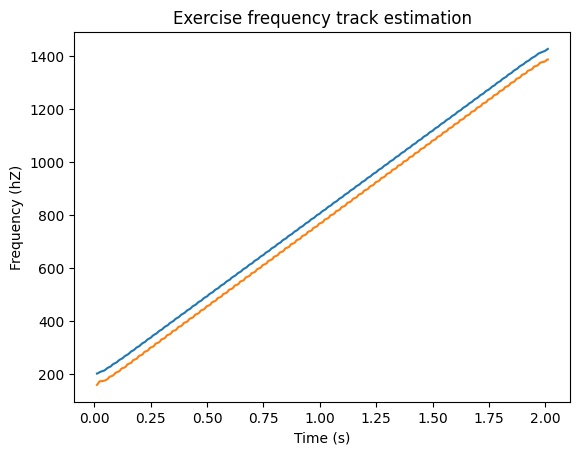

" Explanation\nI computed M by calculatin the formula from the lecture;\nM >= Bs * (fs / delta)\n\nHere, the (constant, in this case) distance between the 2 input frequencies (delta) is important, because\nit is the minimum frequency resolution we want to obtain in all the DFTs of all the time frames.\nThe frequency distance between the 2 sinewaves is (constant) 40 hZ; if we compute M with this value, M = 6615,\nclearly too much. In fact, with M = 6615 we have plenty of frequency resolution, but not enough time resolution,\nand the frequencies tracking is distorted (as can be seen by the plots with that value of M).\nThis would not be the same (the time resolution would be less important, and so we could accept a larger value of M)\nif the sinewaves' frequencies were stable rather than going upward in a glissando-like fashion.\nWith the glissando, taking larger portions of the input time domain signal (larger values of M)\nmeans, by calculating the DFT, averaging the amount of energy i

In [5]:
# E5 - 2.1: First call function freq_tracker_error() with the test case values and plot the true versus the 
# estimated frequency values, then change the window-size to obtain minimum possible error, and plot the new 
# estimated frequency values. Explain the choice and result.

import matplotlib.pyplot as plt

# My code
M = 1023
# Not my code

H = 128 
window = 'blackman'
t = -80
input_file = '../sounds/chirp-150-190-linear.wav'
fs, x = UF.wavread(input_file) 
tStamps = gen_time_stamps(x.size, M, fs, H)   
fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps)

### Your code here

meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

plt.plot(tStamps, fTrackTrue)
plt.title("True frequency values")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (hZ)")
plt.show()

print("Test case Mean error;")
print(meanErr)

plt.plot(tStamps, fTrackEst)
plt.title("Test case frequency track estimation")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (hZ)")
plt.show()

# CALCULATING VALUE FOR M
# M >= Bs * (fs / delta)
# M is equal or greater than
# (window main lobe width * (fs / minimum frequency difference we want to measure in the frequency domain))

M = int(6 * (fs / 60)) # Blackman window main lobe width is 6 bins

meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

print("Computed M;")
print(M)

print("Exercise Mean error;")
print(meanErr)

plt.plot(tStamps, fTrackEst)
plt.title("Exercise frequency track estimation")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (hZ)")
plt.show()

""" Explanation
I computed M by calculatin the formula from the lecture;
M >= Bs * (fs / delta)

Here, the (constant, in this case) distance between the 2 input frequencies (delta) is important, because
it is the minimum frequency resolution we want to obtain in all the DFTs of all the time frames.
The frequency distance between the 2 sinewaves is (constant) 40 hZ; if we compute M with this value, M = 6615,
clearly too much. In fact, with M = 6615 we have plenty of frequency resolution, but not enough time resolution,
and the frequencies tracking is distorted (as can be seen by the plots with that value of M).
This would not be the same (the time resolution would be less important, and so we could accept a larger value of M)
if the sinewaves' frequencies were stable rather than going upward in a glissando-like fashion.
With the glissando, taking larger portions of the input time domain signal (larger values of M)
means, by calculating the DFT, averaging the amount of energy in each frequency bin for a longer period of time;
since the frequencies of both sinusoids are constantly changing, this would distort the frequency domain representation.

As we start to reduce M by enlarging the delta (50 hZ rather than 40 hZ), tracking improves.
Finally, with a minimum distance of 60 hZ we have reached an acceptable time/frequency compromise, and the mean 
frequency estimation error is within the acceptability threshold.

The formulas for M give us an idea of, given a minimum frequency resolution needed, the minimum value that M
needs to have in order to guarantee it.
But, with partials that change in frequency, time domain resolution (opposite than frequency domain resolution)
comes also into account and an acceptable time frequency compromise has to be reached.
"""

## Part 3 -Tracking sinusoids of different amplitudes 

In this part you should perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`. 

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`. 

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`. 

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid. 

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` should be specified in negative dB.

NOTE: Do not do just trial and error. Understand the problem and calculate and `M` that should work. Then test it and refine the answer.

__Test case:__ Choosing `window = 'hanning'`, `t = -80.0`, the mean estimation error is `[0.19603701  29.51140815]` Hz. 


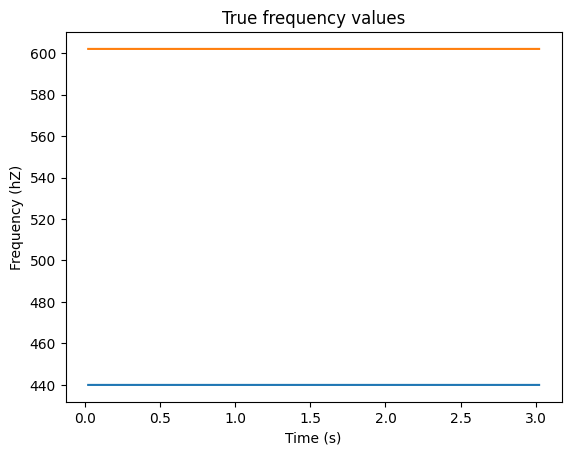

Test case mean estimation error;
[ 0.19603701 29.51140815]


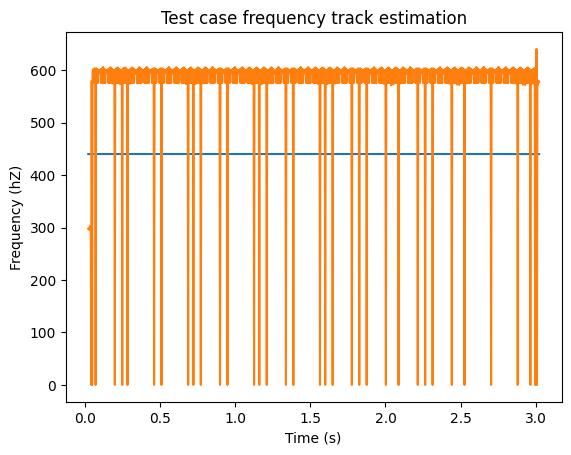

Exercise mean estimation error;
[0.03843794 0.06193923]


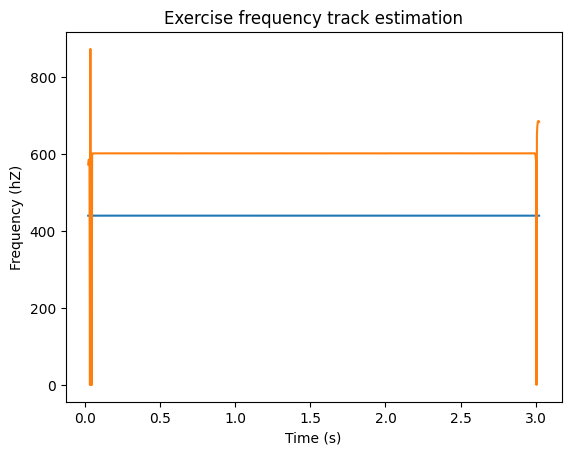

Computed minimum M;
1088


'Explanation\nI think the Blackman-harris window (wide main lobe but very low side lobes)\ndoes a good job here; we can clearly distinguish a 440 hZ component, and a 602 hZ component.\nWith a magnitude threshold of -60 dB, the upper frequency disappears, so we have to use a lower threshold\n(-70 dB or lower).\n\nAlso the Blackman window performs good, but the upper frequency track is slightly less "clear" and "stable"\ncomparing to the results from the Blackman-harris window (mean estimation error for higher and softer frequency\nwould be higher; 2.38234055).\nThis happens because the Blackman window has narrower main lobe but higher side lobes than the Blackman-harris,\nand the side lobes of the louder frequency slightly mask the main lobe of the softer frequency.\n\nThe Hamming window, for example, performs worse for our purposes; depending on the threshold value,\nthe upper frequency is represented at 530/540 hZ or 330/340 hZ.\nThat is actually one of the side lobes of the lower and

In [6]:
# E5 - 3.1: First call freq_tracker_error() with the values for the test case and plot the true versus the 
# estimated frequency values. Then choose the window and threshold to obtain minimum possible error, and plot 
# the new estimated frequency values. Explain the result.
    
M = 2047                                             # Window size 
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)  
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

### Your code here

plt.plot(tStamps, fTrackTrue)
plt.title("True frequency values")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (hZ)")
plt.show()

window = 'hann'
t = -80.0
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

print("Test case mean estimation error;")
print(meanErr)

plt.plot(tStamps, fTrackEst)
plt.title("Test case frequency track estimation")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (hZ)")
plt.show()

window = 'blackmanharris'
t = -70.0
meanErr, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

print("Exercise mean estimation error;")
print(meanErr)

plt.plot(tStamps, fTrackEst)
plt.title("Exercise frequency track estimation")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (hZ)")
plt.show()

# OPTIONAL formula for calculating M (test)
m = int(8 * (fs / ((602 - 440) * 2))) # Blackmanharris window has a main lobe of width 8 bins
print("Computed minimum M;")
print(m)

"""Explanation
I think the Blackman-harris window (wide main lobe but very low side lobes)
does a good job here; we can clearly distinguish a 440 hZ component, and a 602 hZ component.
With a magnitude threshold of -60 dB, the upper frequency disappears, so we have to use a lower threshold
(-70 dB or lower).

Also the Blackman window performs good, but the upper frequency track is slightly less "clear" and "stable"
comparing to the results from the Blackman-harris window (mean estimation error for higher and softer frequency
would be higher; 2.38234055).
This happens because the Blackman window has narrower main lobe but higher side lobes than the Blackman-harris,
and the side lobes of the louder frequency slightly mask the main lobe of the softer frequency.

The Hamming window, for example, performs worse for our purposes; depending on the threshold value,
the upper frequency is represented at 530/540 hZ or 330/340 hZ.
That is actually one of the side lobes of the lower and louder frequency, not the main lobe of the upper and softer frequency.

Boxcar gives probably the worst result, even with high magnitude thresholds.

All the above results can be proven also with a spectrogram calculated with models_GUI.py.
The Blackmanharris window results in the most clear couple of distinct sinewaves.

I think we can deduct that, for musical signals, given a proper (and large enough) value for M
(so that we have enough frequency resolution to space each sinewave apart enough), the blackmanharris
window, having the lowest side lobes, can better guarantee the non-masking of louder components' side lobes
over softer components' main lobes.
This is fundamental, since the extracted peaks for the sinusoidal model correspond to the main lobes.

Given the formula M >= Bf * (fs / delta) where delta is the difference between the 2 frequencies ;
M should be at least 1088, is actually much larger, so there is enough frequency resolution for
each sinusoid's main lobes of the Blackmanharris window not to overlap over each other.
I tested a spectrogram with M == 1088, and, because there is no parabolic interpolation, this 
value of M is still not enough. But it would be if parabolic interpolation was applied.
"""

## Part 4 - Sinusoidal modeling of a multicomponent signal

In this part you will perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and explain the difficulties encoutered and solutions found. 

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or Sonic Visualizer to see its spectrogram. 

We have written a basic code for sinusoidal analysis, you are free to modify it. You should be able to generate a sound that is perceptually undistinguishable from the input sound.


Input signal length 264600 
Output signal length 264576 


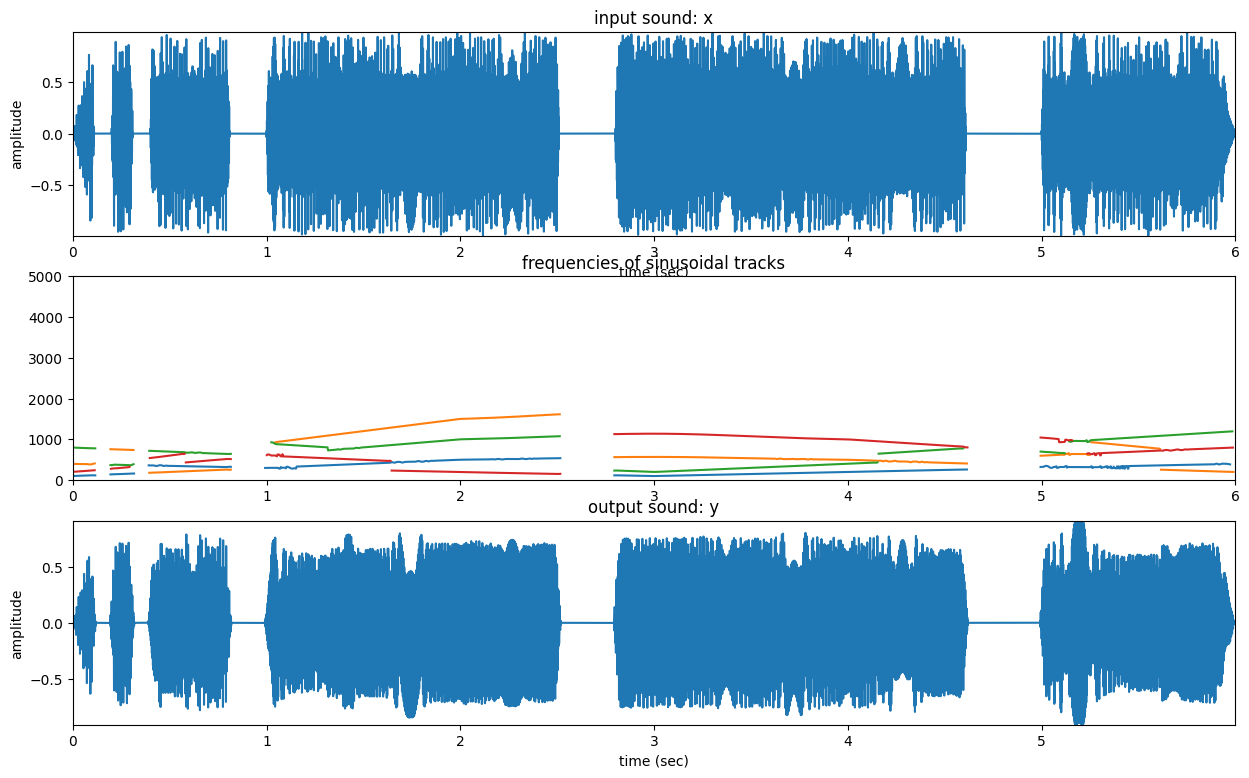

In [8]:
# E5 - 4.1: Set the analysis parameters of sineModelAnal() to perform the best analysis of multiSines.wav

import IPython.display as ipd

input_file = '../sounds/multiSines.wav'

### set the analysis parameters

window = 'blackmanharris'                      
M = 2647                                     
N = 4096                                    
t = -40                                                   
minSineDur = 0.1                     
maxnSines = 4
freqDevOffset = 100
freqDevSlope = 0.02


# no need to modify the code after here
Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (has to be 1/4 of Ns)
    
fs, x = UF.wavread(input_file)                # read input sound
w = get_window(window, M)                     # compute analysis window

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# create figure to show plots
plt.figure(figsize=(15, 9))

# frequency range to plot
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')
                
# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

# OPTIONAL
print(f"Input signal length {len(x)} ")
print(f"Output signal length {len(y)} ")

In [8]:
# Your explanation of Part 4 here

'''
The output signal is shorter than the input signal, due to the last 2 lines of code of the function 
sineModelSynth() from sineModel.py.
This, was done in order to avoid the abrupt discontinuities (0 phase windowing takes into account
centering the center sample at time 0, but of course the first frame presents 0 values in 
the negative time, and the last frame presents 0 values after the end of the signal) in the first and last frame.

The re-synthesis part of sineModelSynth() undoes the analysis Blackmanharris window by applying a triangular window.

I found these values by trial and error, but a high value of M is needed since some sinewaves
are really close to each other.
Given that our delta (smallest frequency difference we want to measure) is 100;
M = 6 (Blackmanharris main lobe width) * (fs / 100) = 2646 (+ 1 to make it odd size window in order to perform 0 phase windowing = 2647)

Most of the distortion in the output signal is added where the frequencies are more close together (t = 1.0 s and t = 5.0 s).

The minimum duration of the tracks can be no longer than 0.1 s, otherwise the shorter "chords" would disappear.

The quite high magnitude threshold (-40 dB) helps not to pick side lobes as peaks,
which would deviate the sinusoidal tracks.

The maxnSines parameter has been evaluated by looking at various spectrograms, with high levels of M (poor time resolution but
high frequency resolution) so that I could be sure about the maximum number of sinewaves simultaneously present in the input signal.

The same has been done for freqDevOffset (at f = 0, how much a track can deviate in its frequency value, in hZ)
and freqDevSlope (how much freqDevOffset changes with respect to frequency).

Of course, being this a kind of "chicken and egg problem", we have to be very careful about the values we
compute the spectrogram with, because they can "confuse" us by showing us what we are not looking for and viceversa.

The best empirical test is always listening to the re-constructed output signal.
'''

'\nThe output signal is shorter than the input signal, due to the last 2 lines of code of the function \nsineModelSynth() from sineModel.py.\nThis, I guess was done in order to avoid the abrupt discontinuities (0 phase windowing takes into account\ncentering the center sample at time 0, but of course the first frame presents 0 values in \nthe negative time, and the last frame presents 0 values after the end of the signal) in the first and last frames.\n\nThe re-synthesis part of sineModelSynth() undoes the analysis Blackmanharris window by applying a triangular window.\n\nI found these values by trial and error, but a high value of M is needed since some sinewaves\nare really close to each other.\nGiven that our delta (smallest frequency difference we want to measure) is 100;\nM = 6 (Blackmanharris main lobe width) * (fs / 100) = 2646\n\nMost of the distortion in the output signal is added where the frequencies are more close together (t = 1.0 s and t = 5.0 s).\n\nThe minimum duration 